In [ ]:
if(! require("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install("fgsea")
BiocManager::install("msigdbr")
if (!requireNamespace("AnnotationDbi", quietly = TRUE)) {
  BiocManager::install("AnnotationDbi")
}
if (!requireNamespace("org.Hs.eg.db", quietly = TRUE)) {
  BiocManager::install("org.Hs.eg.db")
}
BiocManager::install("clusterProfiler", force = TRUE)
install.packages("msigdbdf", repos = "https://igordot.r-universe.dev")
install.packages("pheatmap")

library(tidyverse)
library(fgsea)
library(AnnotationDbi)
library(org.Hs.eg.db)
library(stringr)
library(ggplot2)
library(msigdbr)
library(clusterProfiler)
library(tibble)
library(dplyr)
library(pheatmap)
library(tidyr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.21 (BiocManager 1.30.25), R 4.5.0 (2025-04-11)

Installing package(s) 'BiocVersion', 'fgsea'

also installing the dependencies ‘formatR’, ‘lambda.r’, ‘futile.options’, ‘futile.logger’, ‘snow’, ‘BiocParallel’, ‘cowplot’, ‘fastmatch’, ‘BH’


Old packages: 'httpuv', 'miniUI'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.21 (BiocManager 1.30.25), R 4.5.0 (2025-04-11)

Installing package(s) 'msigdbr'

also installing the dependencies ‘assertthat’, ‘babelgene’


Old packages: 'httpuv', 'miniUI'

'getOption("repos")' replaces Bioco

In [ ]:
# this method genes the gene pathways and genes associated to the subcomponent and then converts it into a dictionary of lists like structure
get_pathway_genes <- function(subcat){
  data <- msigdbr(species = "Homo sapiens", category = "C5", subcategory = subcat)
  subgroups <- split(data$gene_symbol, data$gs_name)
  return(subgroups)
}
# this methods is just converting the ensemble IDs from featureCounts to gene symbols and only keeping the stat and gene name column
get_stats <- function(x){
  data <- read.csv(x)
  data$gene <- gsub("\\..*", "", data$gene)
  data$gene_symbol <- mapIds(org.Hs.eg.db,
                             keys = data$gene,
                             column = "SYMBOL",
                             keytype = "ENSEMBL",
                             multiVals = "first")
  data <- na.omit(data)
  data <- data[!duplicated(data$gene_symbol), ]
  rel_cols <- data[, c("gene_symbol", "stat")]
  return(deframe(rel_cols))
}
subcategories <- c("GO:BP", "GO:CC", "GO:MF")
control_files <- list("estradiol10000" = "/content/log2foldsorted_file_estra10000.csv", "estra1000"="/content/log2foldsorted_file_estra1000no1bg.csv","estra100"="/content/log2foldsorted_file_estra100no1bg.csv","estra10"="/content/log2foldsorted_file_estra10no1bg.csv","estra1"="/content/log2foldsorted_file_estr1no1BG.csv","estra0.1"="/content/log2foldsorted_file_estra0.1no1bg.csv")

In [ ]:
my_stats <- get_stats(control_files$estradiol10000)
pathway_genes <- get_pathway_genes("GO:BP")

cat("Genes in stats:", length(my_stats), "\n")
cat("Unique genes in pathways:", length(unique(unlist(pathway_genes))), "\n") # confirming the whole package is installed
cat("Common genes:", length(intersect(names(my_stats), unique(unlist(pathway_genes)))), "\n")

'select()' returned 1:many mapping between keys and columns

Warning message:
“The `category` argument of `msigdbr()` is deprecated as of msigdbr 10.0.0.
ℹ Please use the `collection` argument instead.”
Warning message:
“The `subcategory` argument of `msigdbr()` is deprecated as of msigdbr 10.0.0.
ℹ Please use the `subcollection` argument instead.”


Genes in stats: 9237 
Unique genes in pathways: 17951 
Common genes: 8144 


'select()' returned 1:many mapping between keys and columns

Saving 7 x 7 in image


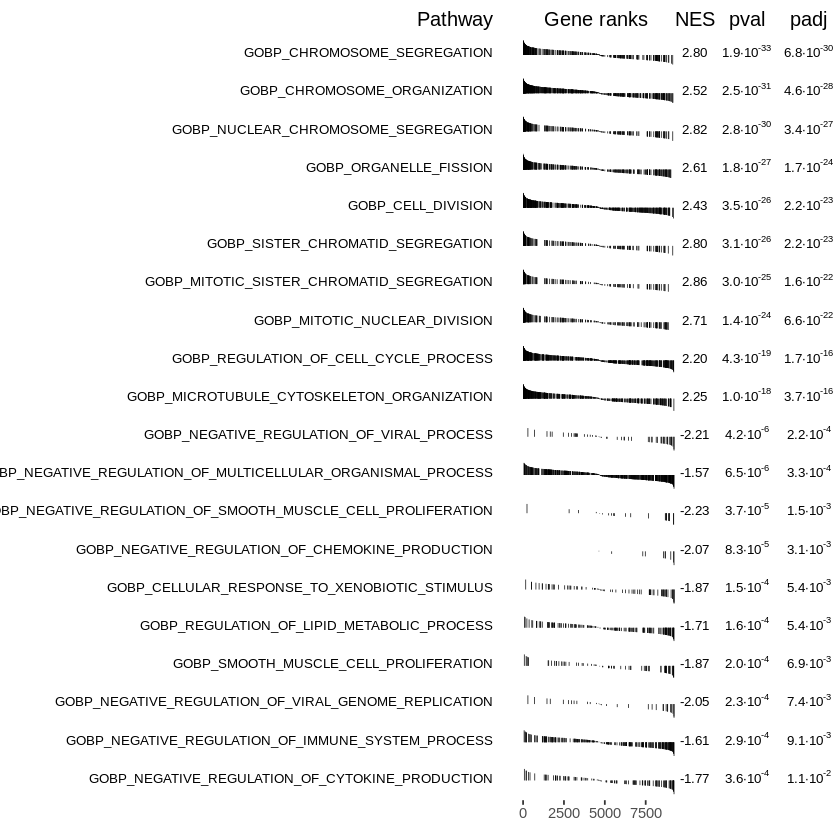

Saving 7 x 7 in image


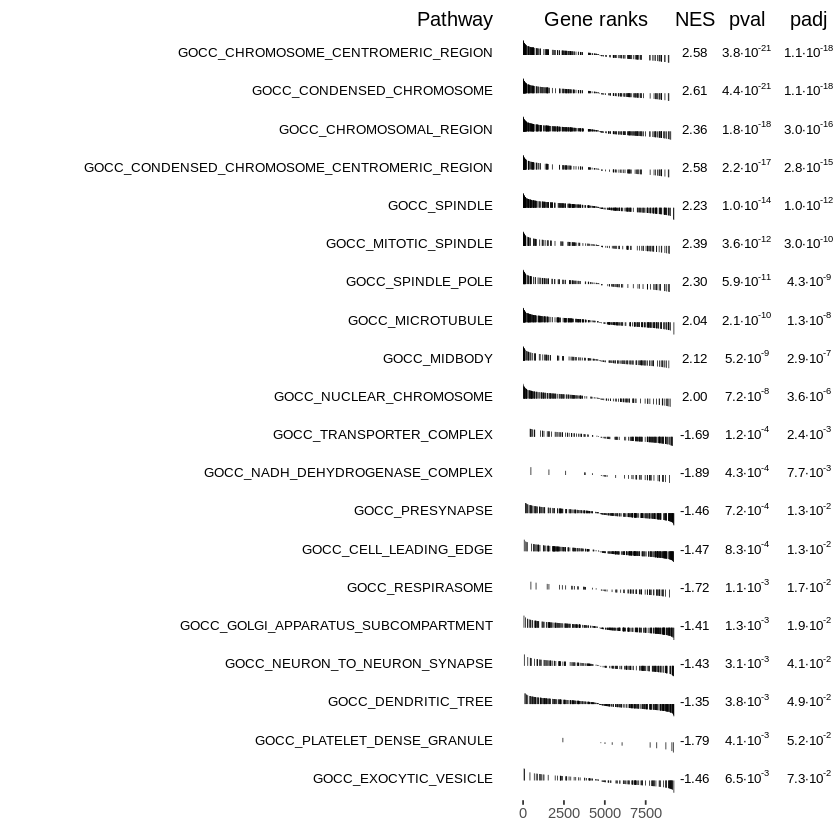

Saving 7 x 7 in image
'select()' returned 1:many mapping between keys and columns



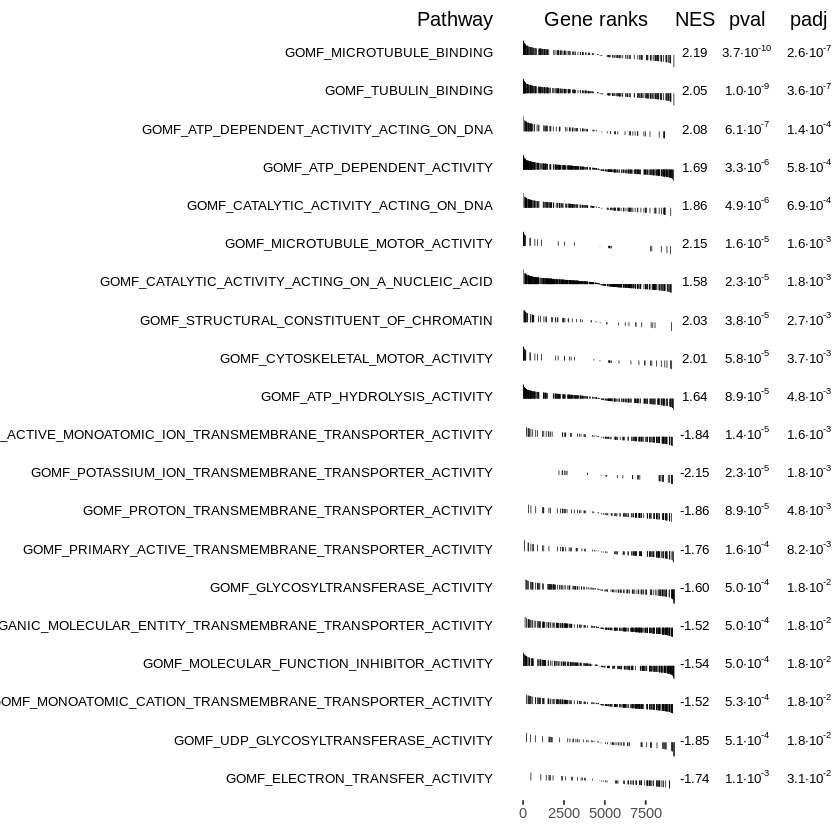

Saving 7 x 7 in image


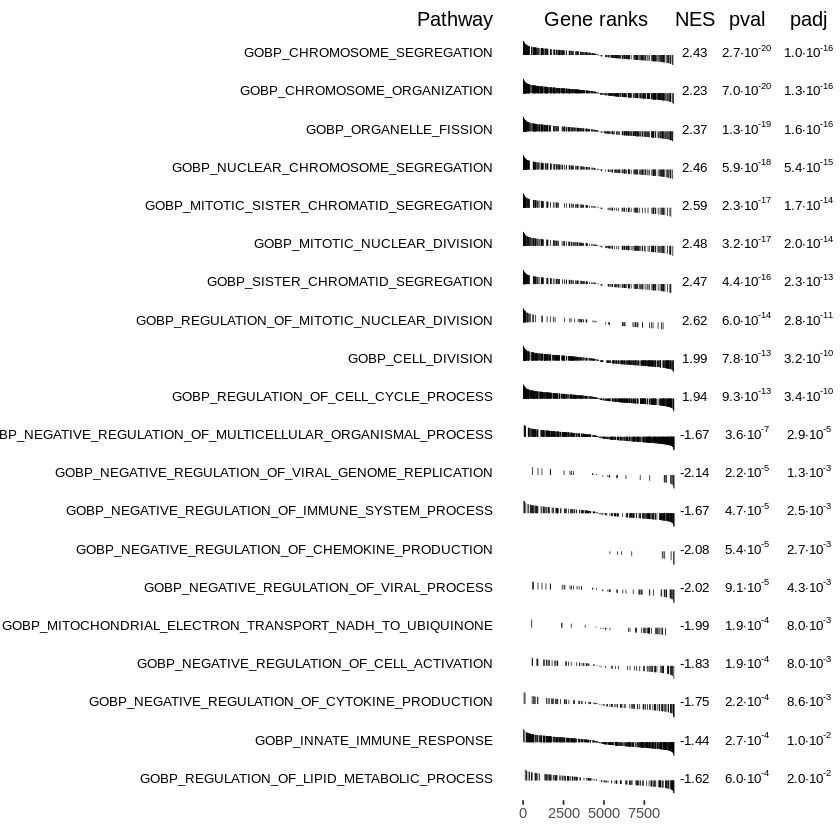

Saving 7 x 7 in image


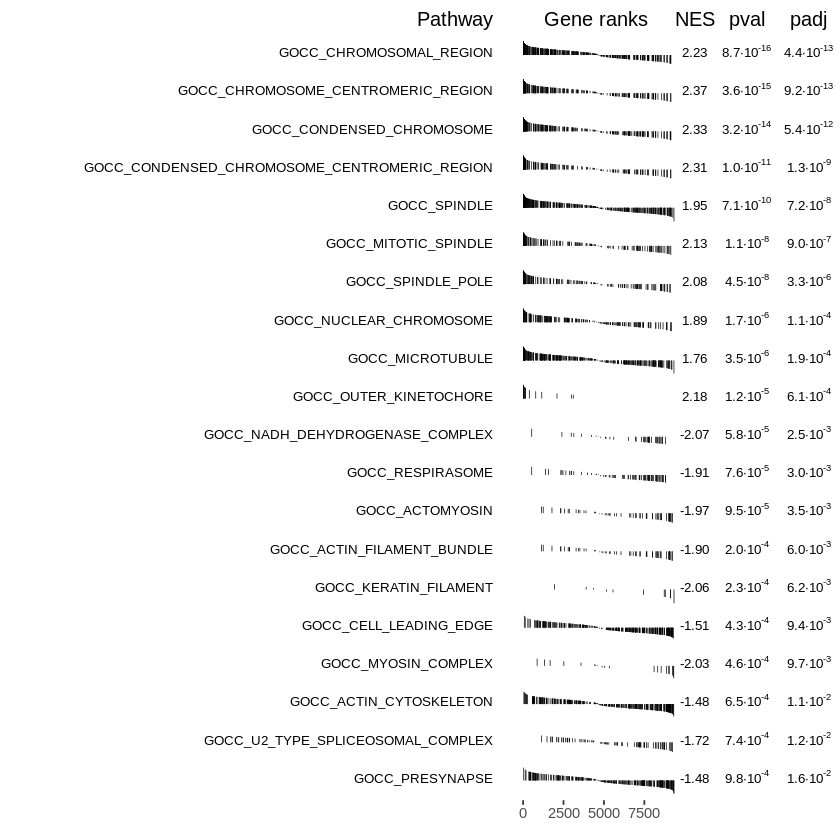

Saving 7 x 7 in image
'select()' returned 1:many mapping between keys and columns



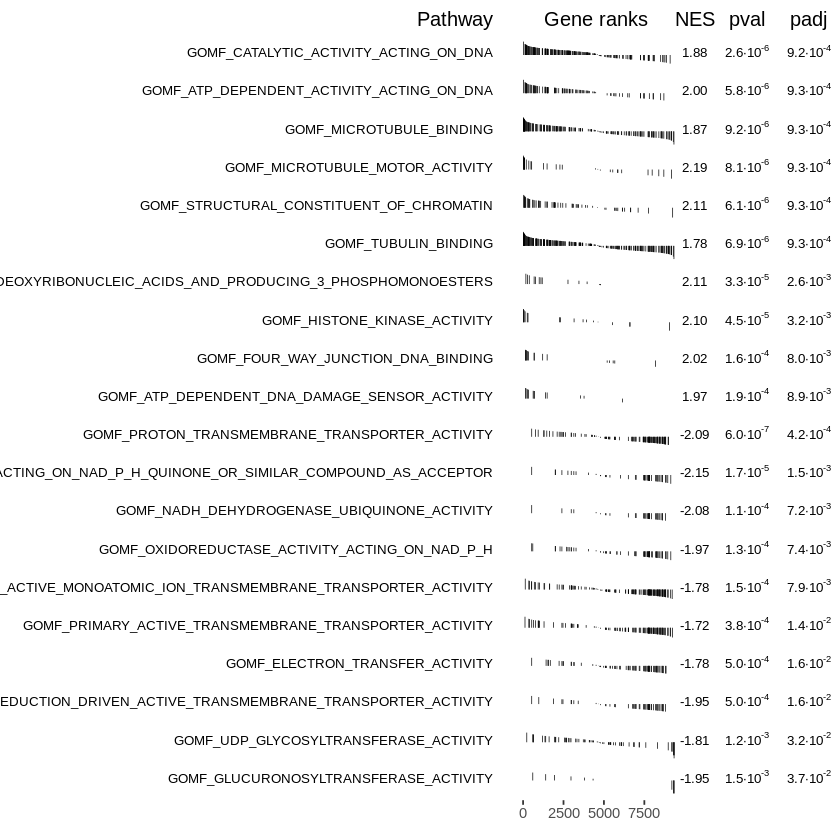

Saving 7 x 7 in image


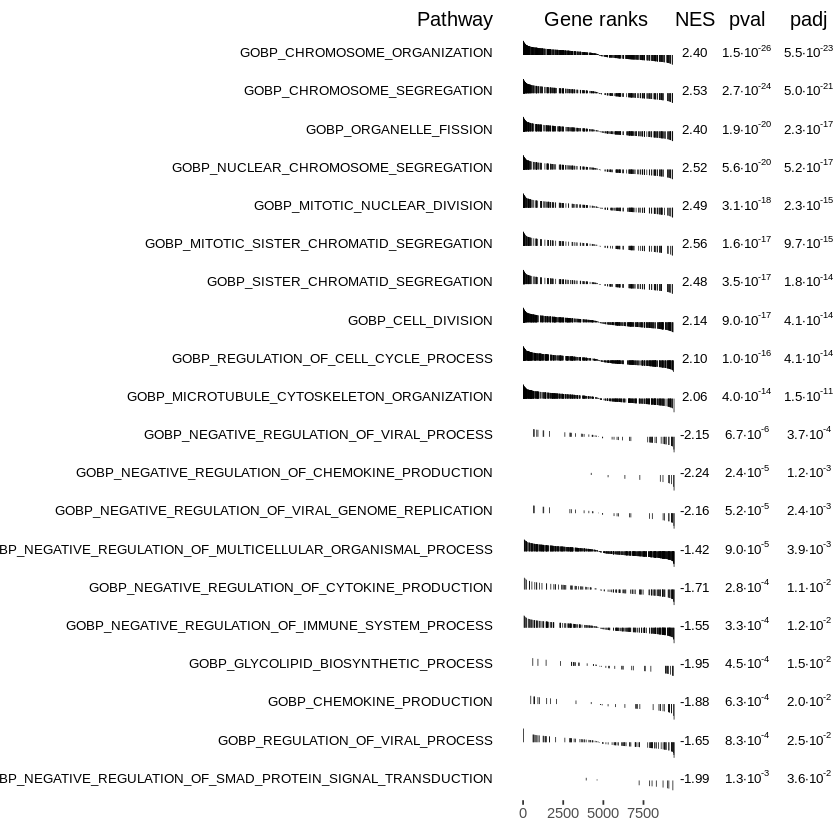

Saving 7 x 7 in image


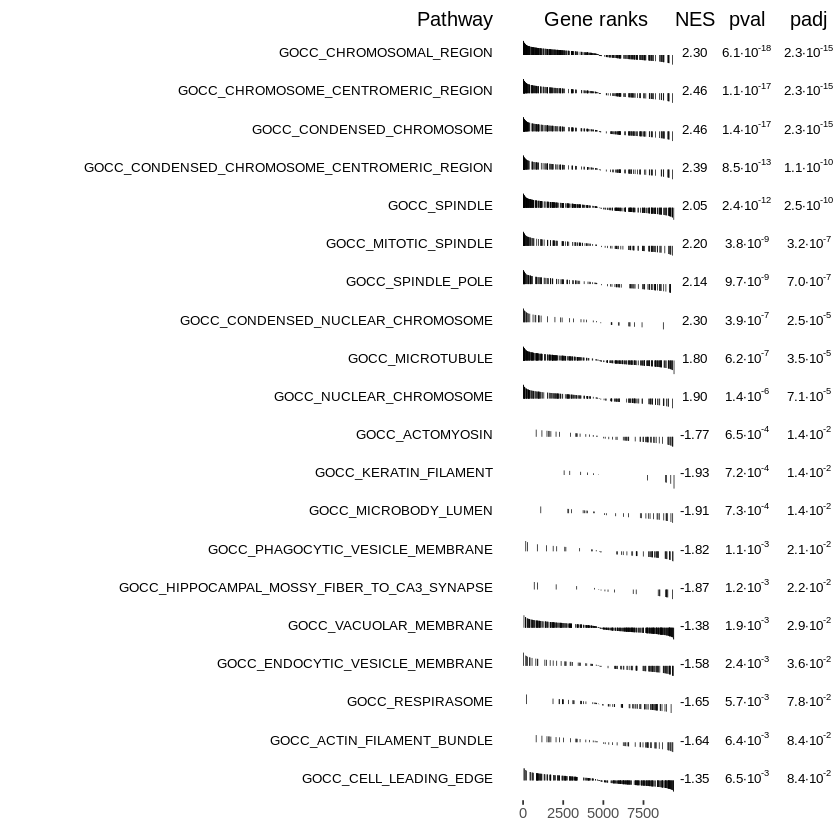

Saving 7 x 7 in image
'select()' returned 1:many mapping between keys and columns



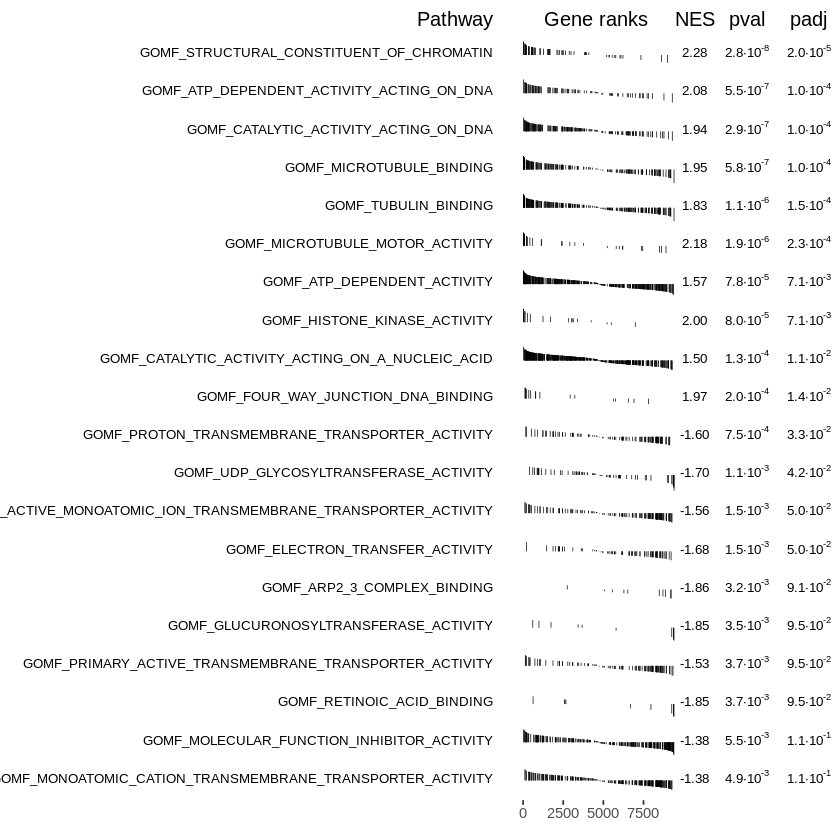

Saving 7 x 7 in image


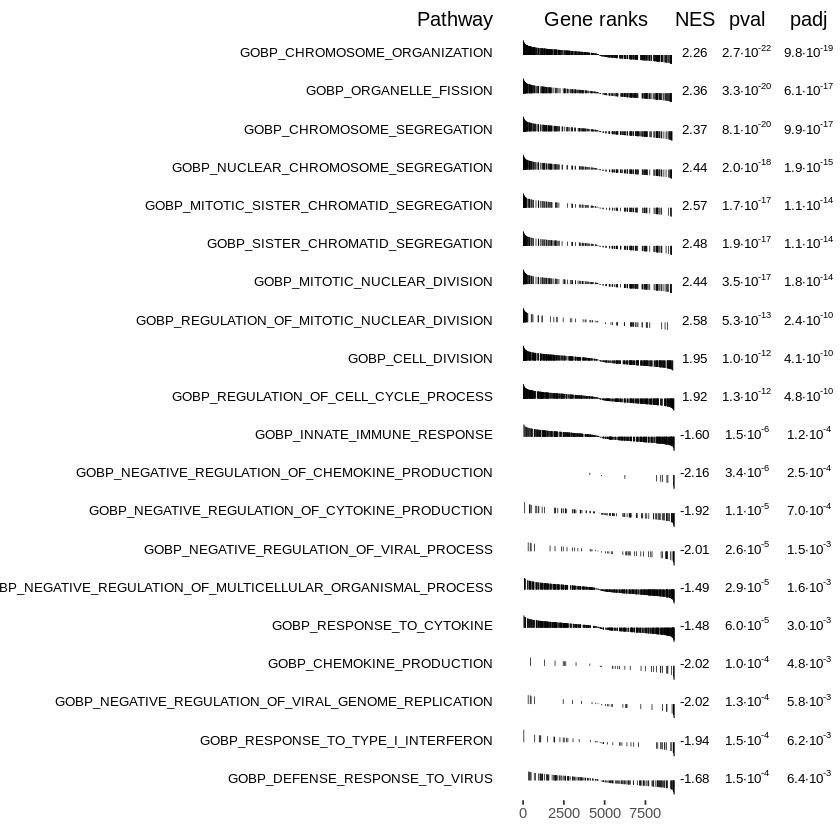

Saving 7 x 7 in image


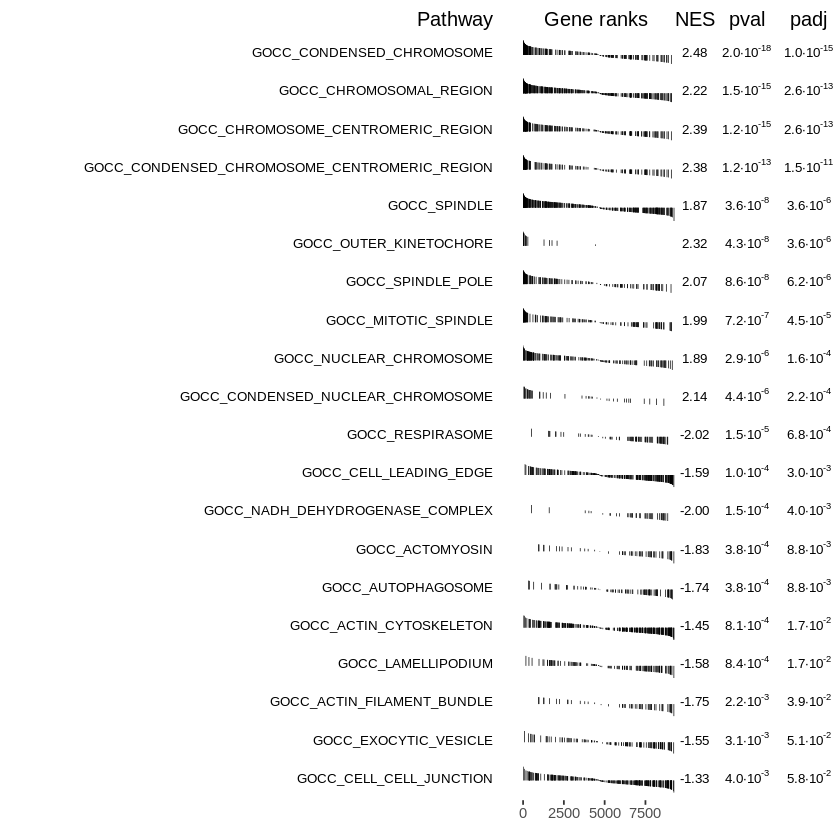

Saving 7 x 7 in image
'select()' returned 1:many mapping between keys and columns



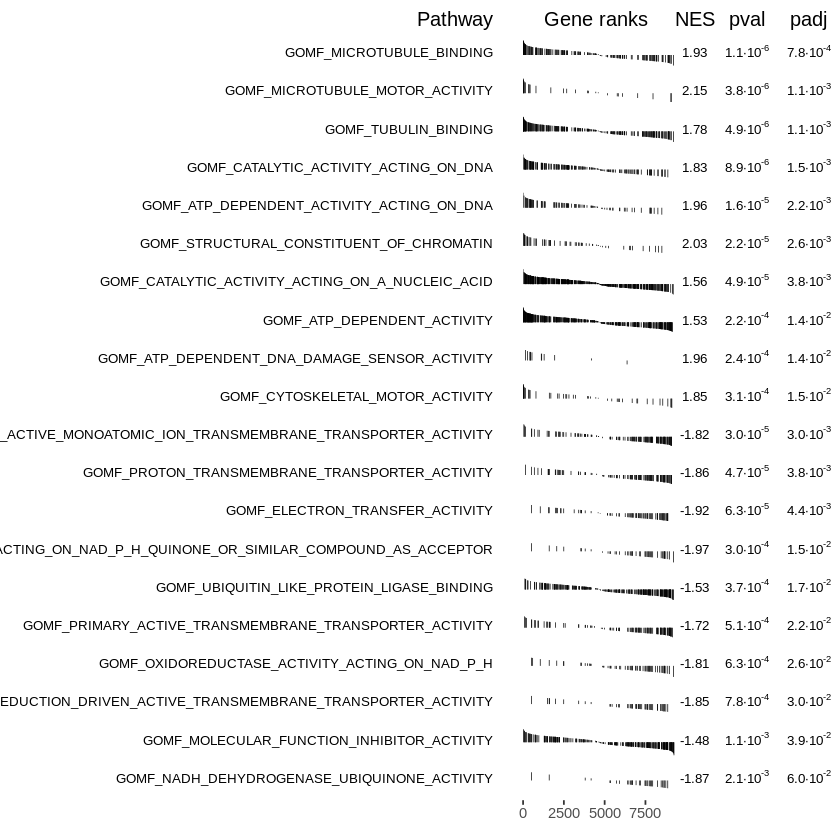

Saving 7 x 7 in image


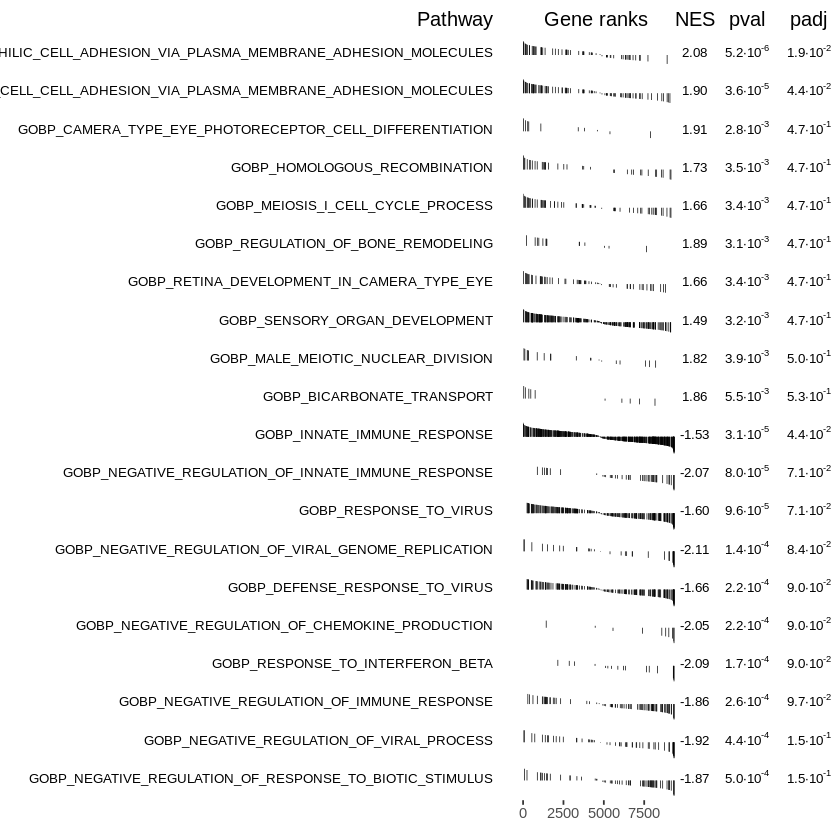

Saving 7 x 7 in image


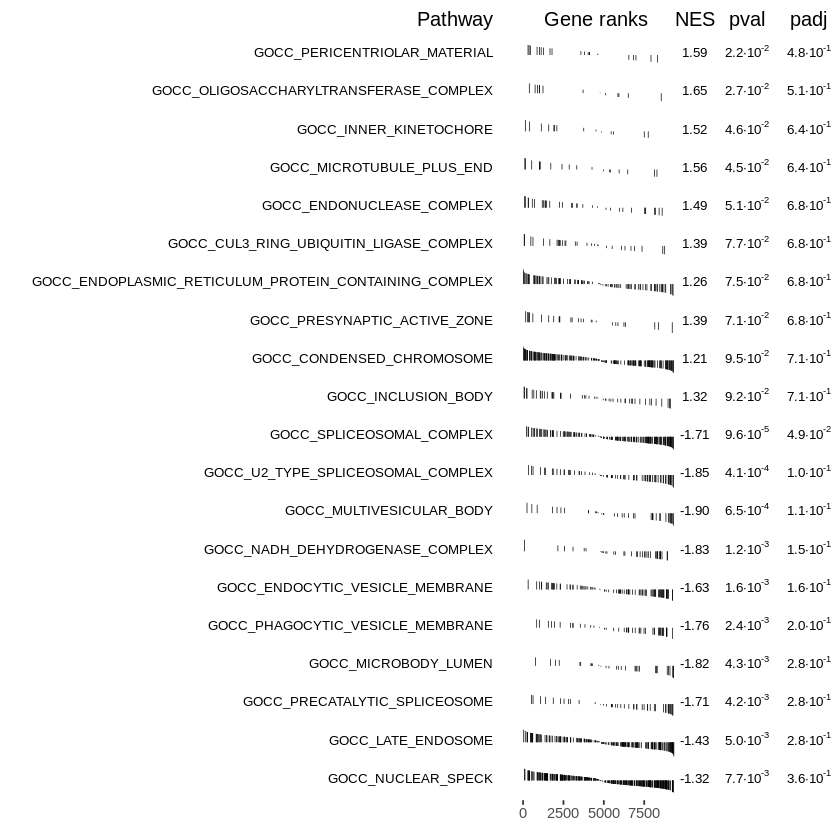

Saving 7 x 7 in image
'select()' returned 1:many mapping between keys and columns



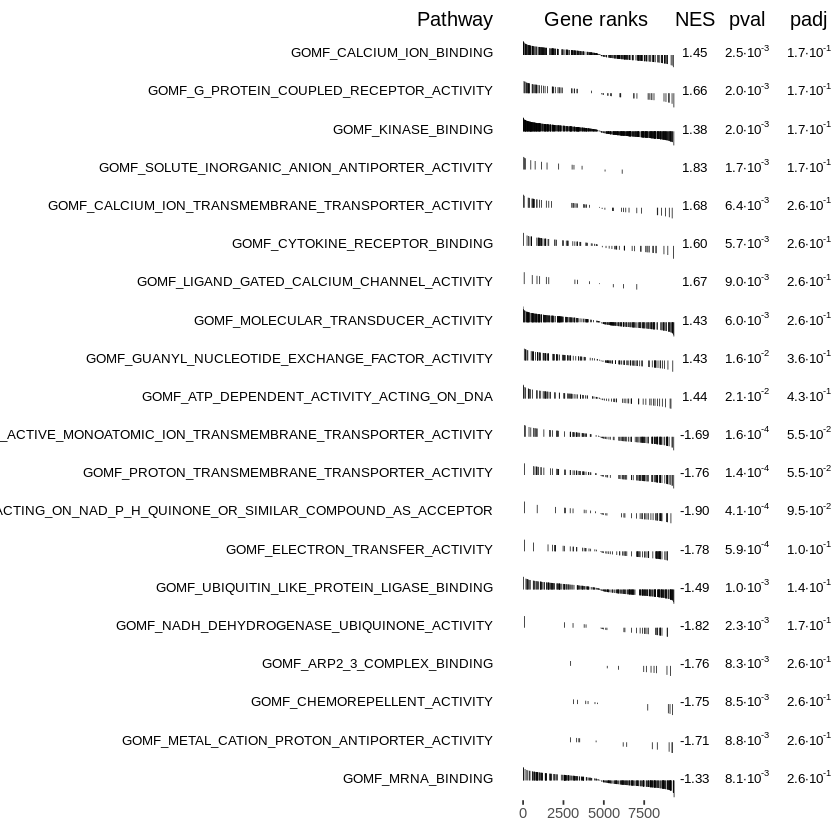

Saving 7 x 7 in image


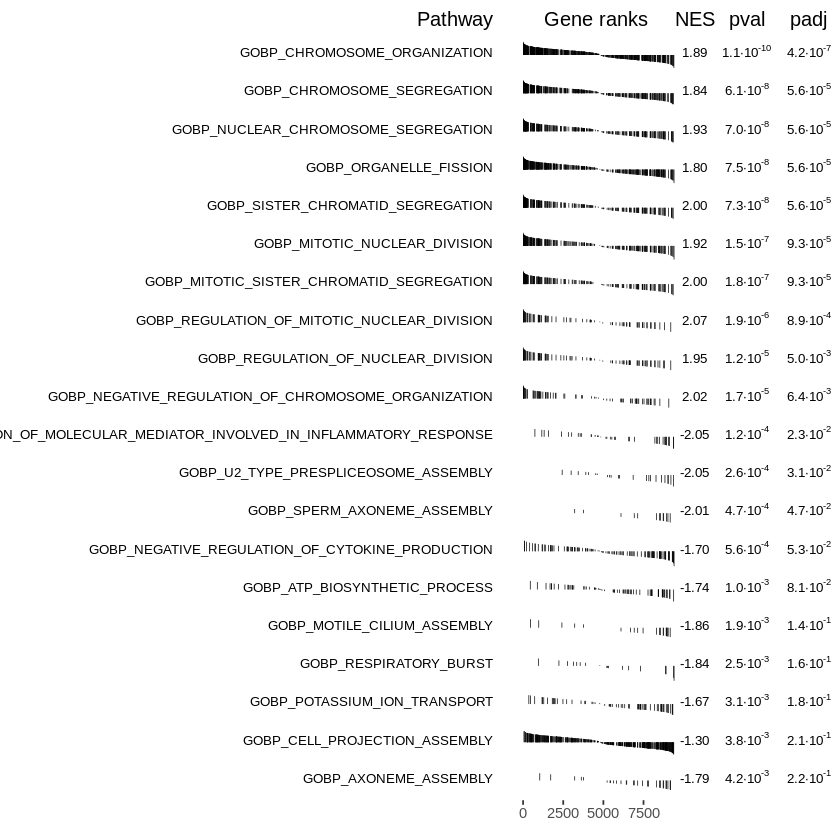

Saving 7 x 7 in image


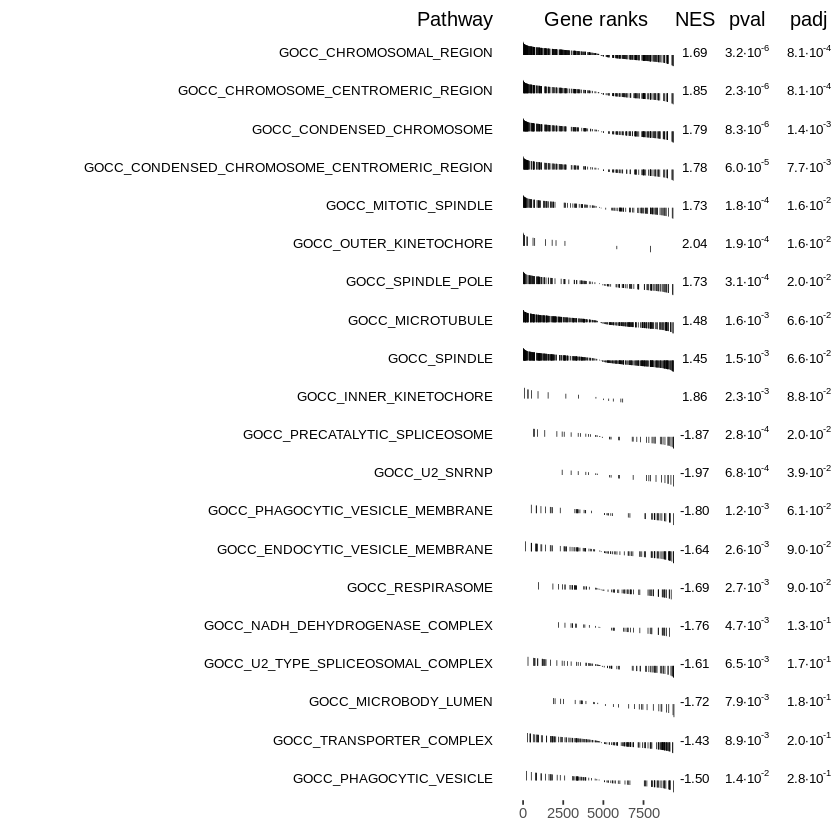

Saving 7 x 7 in image


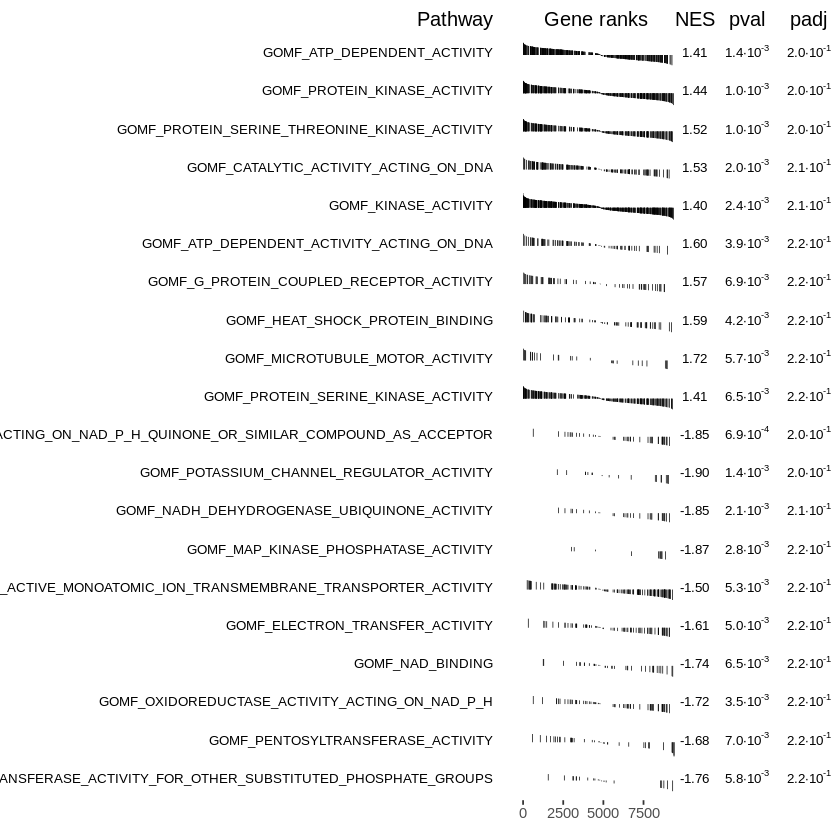

In [ ]:
sig_pathway_counts <- list() # for counts of pathways (this is a list of dataframes)

sig_pathways_by_component <- list( # for common pathways
  "GO:BP" = list(),
  "GO:CC" = list(),
  "GO:MF" = list()
)

heatmap_data_list <- list() # for heatmaps

for (i in names(control_files)) {
  file <- control_files[[i]]
  my_stats <- get_stats(file)
  #print(my_stats)
  my_stats
  my_stats <- my_stats[!is.na(names(my_stats)) & is.finite(my_stats)] # remove NAs and infinite values

  score_type <- if (all(my_stats > 0)) "pos" else if (all(my_stats < 0)) "neg" else "std"

  for (j in subcategories) {
    pathway_genes <- get_pathway_genes(j)
    pathway_genes <- pathway_genes[lengths(pathway_genes) > 0]
    if (length(pathway_genes) == 0) {
    warning(paste("Genes missing for:", j))
    next}
    #my_stats <- my_stats[names(my_stats) %in% unlist(pathway_genes)]

    # if (length(my_stats) == 0) {
    #   warning(paste("Something is wrong in:", j))
    #   next
    # }
    res <- fgsea(
      pathways = pathway_genes,
      stats = my_stats,
      eps = 0.0,
      scoreType = score_type,
      minSize = 10,
      maxSize = 500
    )

    sig_count <- sum(res$padj < 0.05, na.rm = TRUE)
    sig_pathway_counts[[length(sig_pathway_counts) + 1]] <- data.frame(
    concentration = i,
    category = j,
    sig_count = sig_count)

    sig_pathways <- res[padj < 0.05, pathway]
    sig_pathways_by_component[[j]][[i]] <- sig_pathways

    #top 10 up and down pathways
    res_clean <- res[!is.na(padj)]
    topPathwaysUp <- res_clean[NES > 0][order(padj)][1:10, pathway]
    topPathwaysDown <- res_clean[NES < 0][order(padj)][1:10, pathway]
    topPathways <- unique(c(topPathwaysUp, topPathwaysDown))

    top_res <- res[pathway %in% topPathways, .(pathway, NES)]
    top_res$concentration <- i
    top_res$subcomponent <- j

    heatmap_data_list[[paste(i, j, sep = "_")]] <- top_res

    print(plotGseaTable(
      pathway_genes[topPathways],
      my_stats,
      res,
      gseaParam = 0.5,
      colwidths = c(10, 3, 0.8, 1.2, 1.2),
      pathwayLabelStyle = list(size = 8, color = "black"),
      valueStyle = list(size = 8)
    ))
    ggsave(paste(i,j, "top_and_bottom_pathways_fgsea_results.png", sep = "_"))
    #top_leading_edge_genes[, leadingEdge := sapply(leadingEdge, paste, collapse = ";")]
    #write.csv(top_leading_edge_genes, paste0(i, "_", j, "_leading_edge_genes.csv"), row.names = FALSE)
  }
}

CREATING STACKED GRAPHS  FOR DIFFERENTIALLY EXPRESSED PATHWAYS:

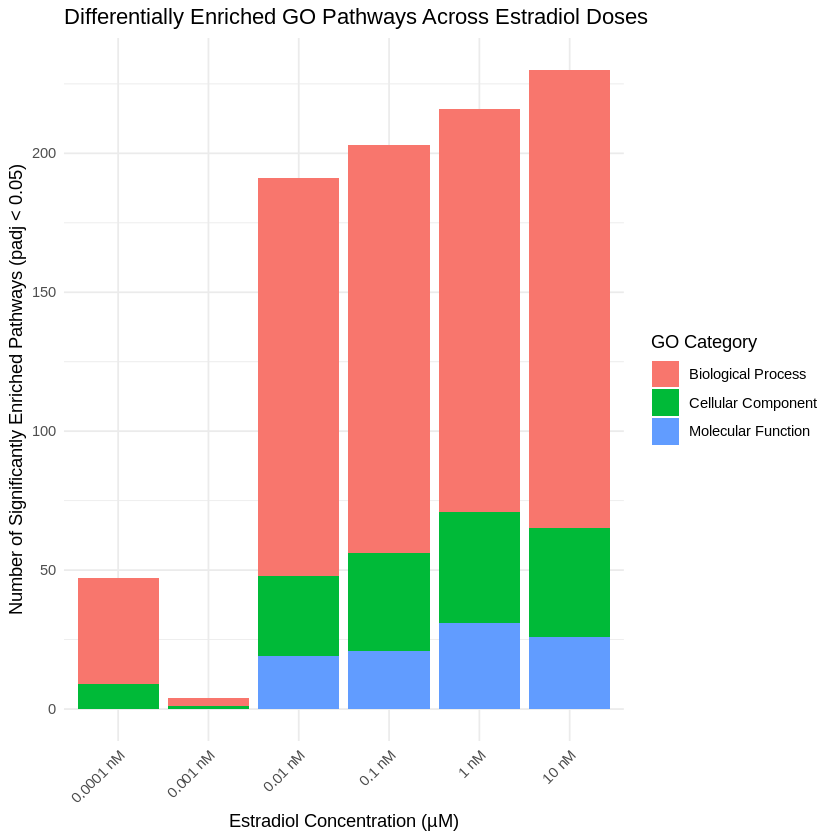

In [ ]:
sig_df <- bind_rows(sig_pathway_counts)
sig_df$category <- factor(sig_df$category,
                          levels = c("GO:BP", "GO:CC", "GO:MF"),
                          labels = c("Biological Process", "Cellular Component", "Molecular Function"))
sig_df$concentration <- factor(sig_df$concentration, levels = c("estra0.1", "estra1", "estra10", "estra100", "estra1000", "estradiol10000"))
levels(sig_df$concentration) <- c("0.0001 nM", "0.001 nM", "0.01 nM", "0.1 nM", "1 nM", "10 nM")
ggplot(sig_df, aes(x = concentration, y = sig_count, fill = category)) +
  geom_bar(stat = "identity") +
  labs(
    x = "Estradiol Concentration (µM)",
    y = "Number of Significantly Enriched Pathways (padj < 0.05)",
    fill = "GO Category",
    title = "Differentially Enriched GO Pathways Across Estradiol Doses"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

Finding commmon pathways among all concentrations:

In [ ]:
top3 <- c("estradiol10000", "estra1000", "estra100")

common_pathways <- lapply(sig_pathways_by_component, function(pathway_lists) {
  top_pathways_only <- pathway_lists[names(pathway_lists) %in% top3]
  Reduce(intersect, top_pathways_only)
})

#print(common_pathways$`GO:BP`)
#print(common_pathways$`GO:CC`)
#print(common_pathways$`GO:MF`)

PLOTTING HEATMAPS FOR EACH SUBCOMPONENTS:

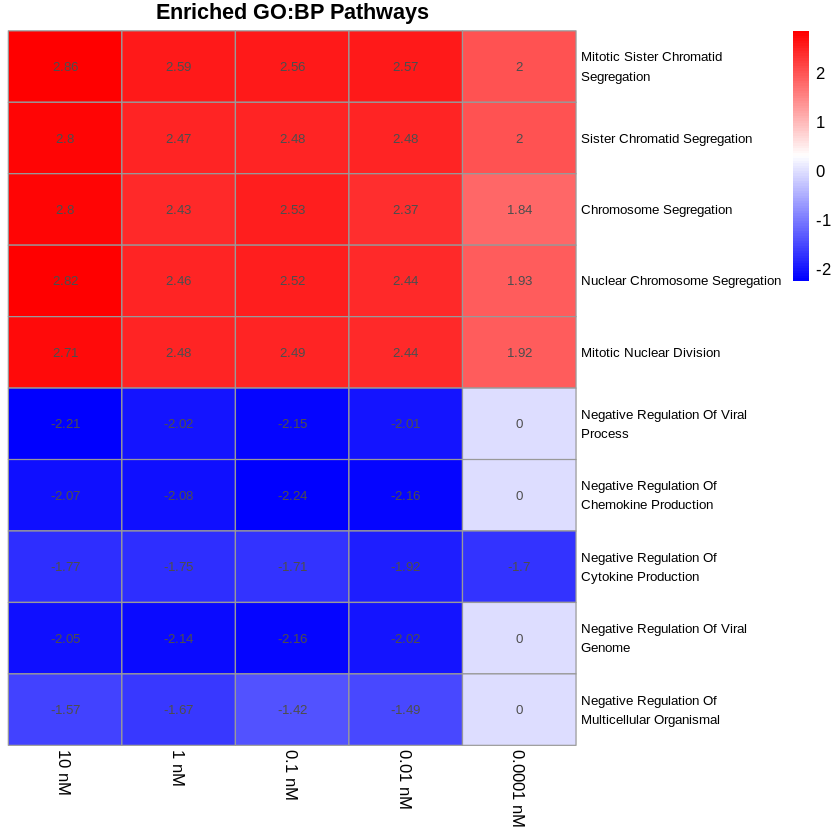

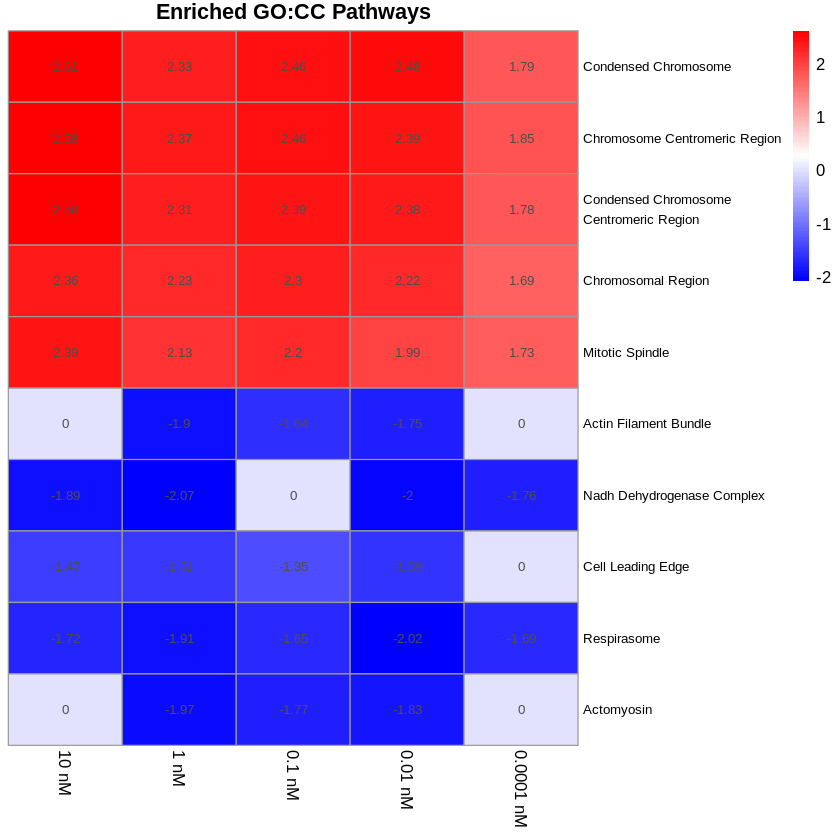

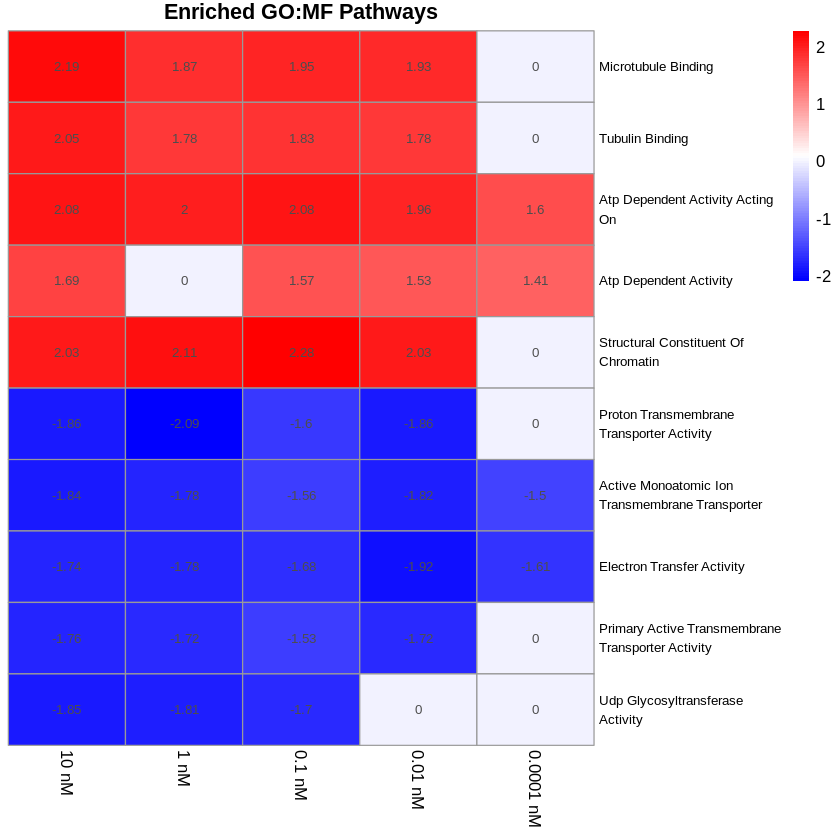

In [ ]:
heatmap_df <- bind_rows(heatmap_data_list)
go_pathways <- list(
  BP = list(
    up = c(
      "GOBP_MITOTIC_SISTER_CHROMATID_SEGREGATION",
      "GOBP_SISTER_CHROMATID_SEGREGATION",
      "GOBP_CHROMOSOME_SEGREGATION",
      "GOBP_NUCLEAR_CHROMOSOME_SEGREGATION",
      "GOBP_MITOTIC_NUCLEAR_DIVISION"
    ),
    down = c(
      "GOBP_NEGATIVE_REGULATION_OF_VIRAL_PROCESS",
      "GOBP_NEGATIVE_REGULATION_OF_CHEMOKINE_PRODUCTION",
      "GOBP_NEGATIVE_REGULATION_OF_CYTOKINE_PRODUCTION",
      "GOBP_NEGATIVE_REGULATION_OF_VIRAL_GENOME_REPLICATION",
      "GOBP_NEGATIVE_REGULATION_OF_MULTICELLULAR_ORGANISMAL_PROCESS"
    )
  ),
  CC = list(
    up = c(
      "GOCC_CONDENSED_CHROMOSOME",
      "GOCC_CHROMOSOME_CENTROMERIC_REGION",
      "GOCC_CONDENSED_CHROMOSOME_CENTROMERIC_REGION",
      "GOCC_CHROMOSOMAL_REGION",
      "GOCC_MITOTIC_SPINDLE"
    ),
    down = c(
      "GOCC_ACTIN_FILAMENT_BUNDLE",
      "GOCC_NADH_DEHYDROGENASE_COMPLEX",
      "GOCC_CELL_LEADING_EDGE",
      "GOCC_RESPIRASOME",
      "GOCC_ACTOMYOSIN"
    )
  ),
  MF = list(
    up = c(
      "GOMF_MICROTUBULE_BINDING",
      "GOMF_TUBULIN_BINDING",
      "GOMF_ATP_DEPENDENT_ACTIVITY_ACTING_ON_DNA",
      "GOMF_ATP_DEPENDENT_ACTIVITY",
      "GOMF_STRUCTURAL_CONSTITUENT_OF_CHROMATIN"
    ),
    down = c(
      "GOMF_PROTON_TRANSMEMBRANE_TRANSPORTER_ACTIVITY",
      "GOMF_ACTIVE_MONOATOMIC_ION_TRANSMEMBRANE_TRANSPORTER_ACTIVITY",
      "GOMF_ELECTRON_TRANSFER_ACTIVITY",
      "GOMF_PRIMARY_ACTIVE_TRANSMEMBRANE_TRANSPORTER_ACTIVITY",
      "GOMF_UDP_GLYCOSYLTRANSFERASE_ACTIVITY"
    )
  )
)
make_go_matrix <- function(df, go_category) {
  df %>%
    filter(subcomponent == paste0("GO:", go_category)) %>%
    select(pathway, concentration, NES) %>%
    pivot_wider(names_from = concentration, values_from = NES, values_fill = 0) %>%
    select(-estra1) %>%
    column_to_rownames("pathway") %>%
    as.matrix()
}
filter_go_matrix <- function(mat, pathways) {
  selected <- c(pathways$up, pathways$down)
  selected_existing <- intersect(selected, rownames(mat))
  mat[selected_existing, , drop = FALSE]
}
# formatting so that the heatmaps can fint
format_heatmap <- function(mat, prefix, n_words = 5, wrap_width = 30, digits = 2) {
  cleaned_names <- rownames(mat) %>%
    gsub(paste0("^GO", prefix, "_"), "", .) %>%
    gsub("_", " ", .) %>%
    str_to_title() %>%
    sapply(function(x) paste(head(strsplit(x, " ")[[1]], n_words), collapse = " ")) %>%
    str_wrap(width = wrap_width)

  rownames(mat) <- cleaned_names
  display_mat <- round(mat, digits = digits)
  list(mat = mat, display = display_mat)
}
plot_go_heatmap <- function(matrix, display_matrix, title) {
  pheatmap(matrix,
           main = title,
           cluster_rows = FALSE,
           cluster_cols = FALSE,
           display_numbers = display_matrix,
           fontsize_number = 8,
           fontsize_row = 8,
           color = colorRampPalette(c("blue", "white", "red"))(100),
           width = 10, height = 8)
}
rename_columns <- function(mat) {
  colnames(mat) <- recode(colnames(mat),
    "estra0.1" = "0.0001 nM",
    "estra1" = "0.001 nM",
    "estra10" = "0.01 nM",
    "estra100" = "0.1 nM",
    "estra1000" = "1 nM",
    "estradiol10000" = "10 nM"
  )
  mat
}
for (go_cat in names(go_pathways)) {
  mat <- make_go_matrix(heatmap_df, go_cat)
  mat_filtered <- filter_go_matrix(mat, go_pathways[[go_cat]])
  mat_filtered <- rename_columns(mat_filtered)
  formatted <- format_heatmap(mat_filtered, prefix = go_cat)
  plot_go_heatmap(formatted$mat, formatted$display, paste0("Enriched GO:", go_cat, " Pathways"))
}

COMPARING THE DATA WITH THE 50 GENE BIOMARKERS FOR ESTROGEN RESPONSE

'select()' returned 1:many mapping between keys and columns



               pathway         pval         padj   log2err        ES     NES
                <char>        <num>        <num>     <num>     <num>   <num>
1: Estrogen_Biomarkers 2.158632e-06 2.158632e-06 0.6272567 0.6677561 2.15837
    size  leadingEdge
   <int>       <list>
1:    40 PDZK1, M....
             Gene       Log2FC Reference    Regulation Reference_Regulation
PRSS23     PRSS23  0.642980382    1.3686   Upregulated          Upregulated
PDZK1       PDZK1  3.330265276    1.4229   Upregulated          Upregulated
RET           RET  1.377156788    1.6957   Upregulated          Upregulated
PGR           PGR  2.731096908    1.3750   Upregulated          Upregulated
CXCL12     CXCL12  1.300795693    1.6200   Upregulated          Upregulated
RAPGEFL1 RAPGEFL1  1.722123984    1.4629   Upregulated          Upregulated
CA12         CA12  0.911085470    1.3283   Upregulated          Upregulated
MYB           MYB  1.560941451    1.2700   Upregulated          Upregulated
AREG         AREG  

'select()' returned 1:many mapping between keys and columns



               pathway         pval         padj   log2err        ES      NES
                <char>        <num>        <num>     <num>     <num>    <num>
1: Estrogen_Biomarkers 2.148245e-06 2.148245e-06 0.6272567 0.6527145 2.207995
    size  leadingEdge
   <int>       <list>
1:    41 PDZK1, P....


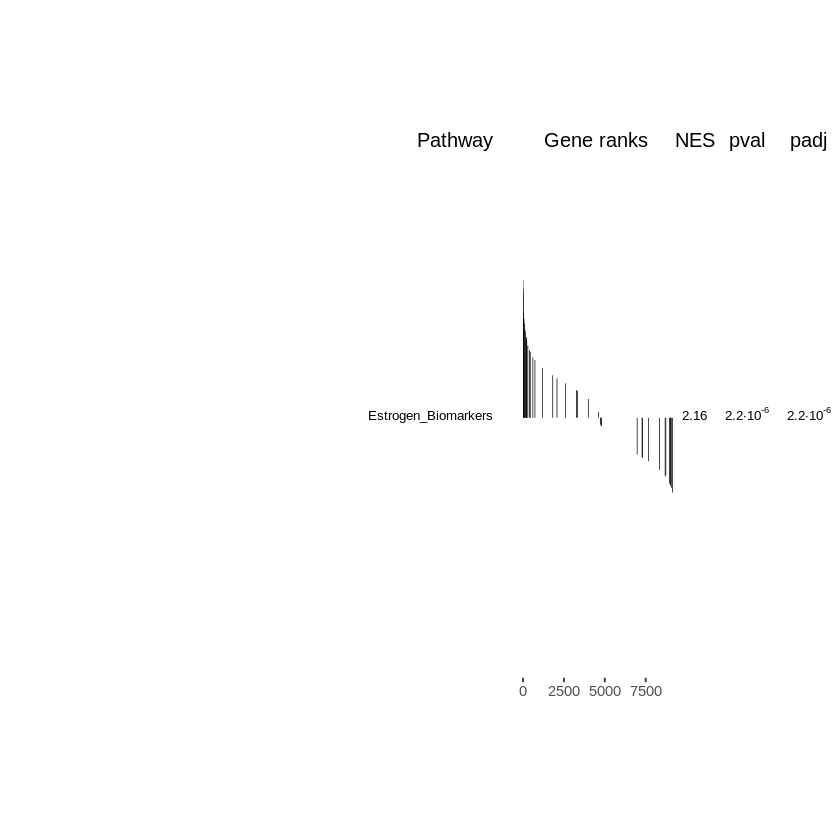

             Gene       Log2FC Reference    Regulation Reference_Regulation
PRSS23     PRSS23  0.665898396    1.3686   Upregulated          Upregulated
PDZK1       PDZK1  3.273989138    1.4229   Upregulated          Upregulated
RET           RET  1.618303723    1.6957   Upregulated          Upregulated
PGR           PGR  2.619664243    1.3750   Upregulated          Upregulated
CXCL12     CXCL12  1.690292662    1.6200   Upregulated          Upregulated
RAPGEFL1 RAPGEFL1  2.103515948    1.4629   Upregulated          Upregulated
CA12         CA12  0.933699438    1.3283   Upregulated          Upregulated
MYB           MYB  1.589257646    1.2700   Upregulated          Upregulated
AREG         AREG  1.980694251    1.5957   Upregulated          Upregulated
RCL1         RCL1  0.667322438    1.2917   Upregulated          Upregulated
CD44         CD44  0.446446778    1.4567   Upregulated          Upregulated
EFNA1       EFNA1 -0.228768552   -1.4800 Downregulated        Downregulated
CCNG2       

'select()' returned 1:many mapping between keys and columns



               pathway         pval         padj   log2err        ES      NES
                <char>        <num>        <num>     <num>     <num>    <num>
1: Estrogen_Biomarkers 7.682388e-07 7.682388e-07 0.6594444 0.6644959 2.177888
    size  leadingEdge
   <int>       <list>
1:    41 PDZK1, P....


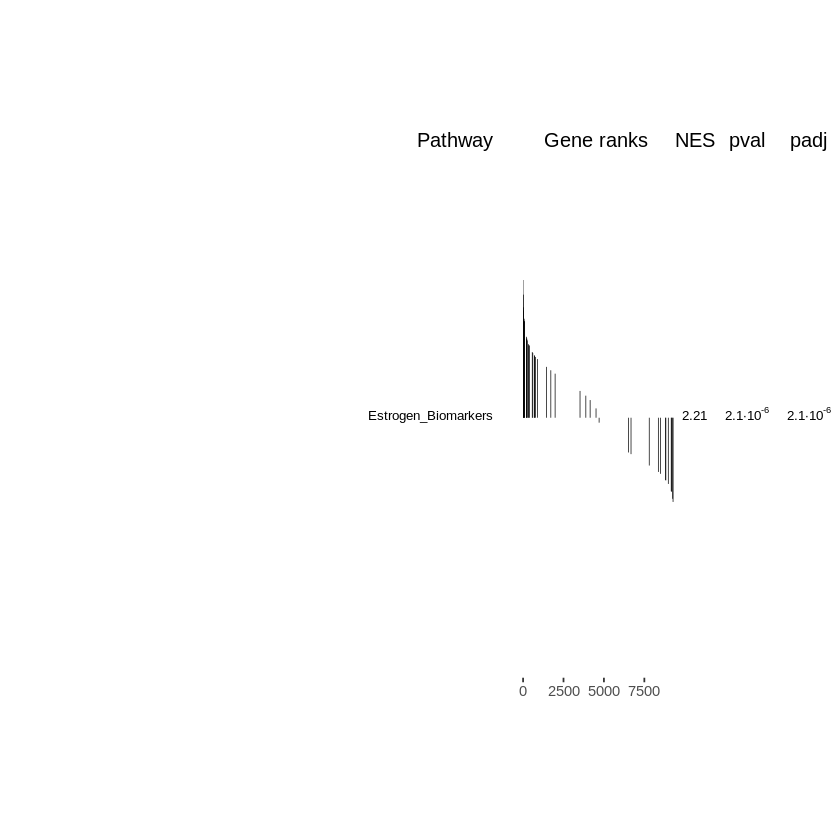

             Gene      Log2FC Reference    Regulation Reference_Regulation
PRSS23     PRSS23  0.27978997    1.3686   Upregulated          Upregulated
PDZK1       PDZK1  3.13143858    1.4229   Upregulated          Upregulated
RET           RET  1.75261923    1.6957   Upregulated          Upregulated
PGR           PGR  2.62101616    1.3750   Upregulated          Upregulated
CXCL12     CXCL12  1.48678070    1.6200   Upregulated          Upregulated
RAPGEFL1 RAPGEFL1  1.85997364    1.4629   Upregulated          Upregulated
CA12         CA12  0.83516834    1.3283   Upregulated          Upregulated
MYB           MYB  1.49758807    1.2700   Upregulated          Upregulated
AREG         AREG  1.95212154    1.5957   Upregulated          Upregulated
RCL1         RCL1  0.48643385    1.2917   Upregulated          Upregulated
CD44         CD44  0.39559950    1.4567   Upregulated          Upregulated
EFNA1       EFNA1 -0.17444550   -1.4800 Downregulated        Downregulated
CCNG2       CCNG2 -0.1956

'select()' returned 1:many mapping between keys and columns



               pathway         pval         padj   log2err        ES      NES
                <char>        <num>        <num>     <num>     <num>    <num>
1: Estrogen_Biomarkers 4.933754e-05 4.933754e-05 0.5573322 0.6018821 2.025436
    size  leadingEdge
   <int>       <list>
1:    41 PGR, MYB....


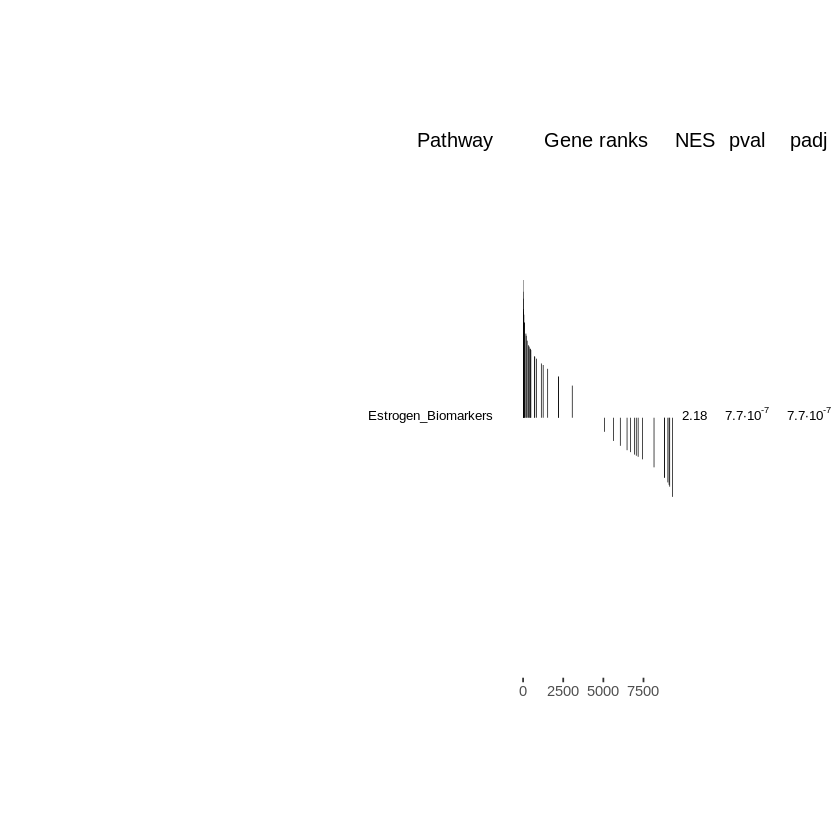

             Gene      Log2FC Reference    Regulation Reference_Regulation
PRSS23     PRSS23  0.05860502    1.3686   Upregulated          Upregulated
PDZK1       PDZK1  1.76108314    1.4229   Upregulated          Upregulated
RET           RET  1.19256149    1.6957   Upregulated          Upregulated
PGR           PGR  1.97228337    1.3750   Upregulated          Upregulated
CXCL12     CXCL12  1.05385395    1.6200   Upregulated          Upregulated
RAPGEFL1 RAPGEFL1  1.37083948    1.4629   Upregulated          Upregulated
CA12         CA12  0.69083331    1.3283   Upregulated          Upregulated
MYB           MYB  1.15858578    1.2700   Upregulated          Upregulated
AREG         AREG  0.92854047    1.5957   Upregulated          Upregulated
RCL1         RCL1  0.20383029    1.2917   Upregulated          Upregulated
CD44         CD44  0.20375632    1.4567   Upregulated          Upregulated
EFNA1       EFNA1  0.04167320   -1.4800   Upregulated        Downregulated
CCNG2       CCNG2 -0.2571

'select()' returned 1:many mapping between keys and columns



               pathway      pval      padj   log2err         ES       NES  size
                <char>     <num>     <num>     <num>      <num>     <num> <int>
1: Estrogen_Biomarkers 0.3647059 0.3647059 0.1067299 -0.2861226 -1.051651    39
    leadingEdge
         <list>
1: PLAUR, T....


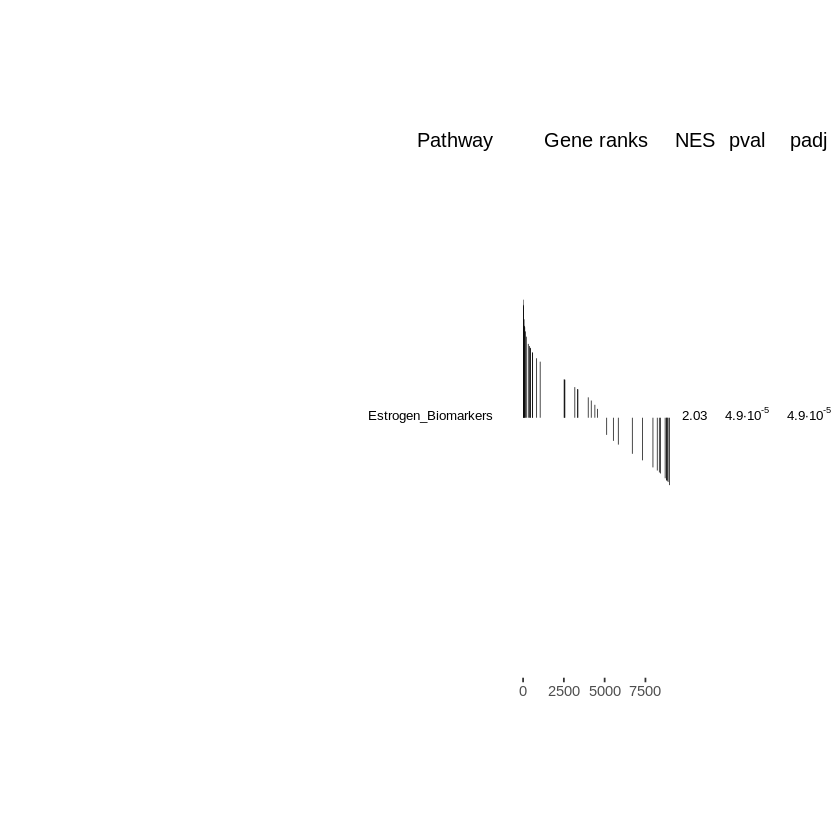

             Gene       Log2FC Reference    Regulation Reference_Regulation
PRSS23     PRSS23 -0.531593294    1.3686 Downregulated          Upregulated
RET           RET  0.001725523    1.6957   Upregulated          Upregulated
PGR           PGR  0.590617984    1.3750   Upregulated          Upregulated
CXCL12     CXCL12  0.016685586    1.6200   Upregulated          Upregulated
RAPGEFL1 RAPGEFL1  0.197171192    1.4629   Upregulated          Upregulated
CA12         CA12  0.278425824    1.3283   Upregulated          Upregulated
MYB           MYB  0.511824170    1.2700   Upregulated          Upregulated
AREG         AREG -0.217166008    1.5957 Downregulated          Upregulated
RCL1         RCL1  0.441464720    1.2917   Upregulated          Upregulated
CD44         CD44 -0.209831908    1.4567 Downregulated          Upregulated
EFNA1       EFNA1  0.165546299   -1.4800   Upregulated        Downregulated
CCNG2       CCNG2 -0.011709210   -1.7650 Downregulated        Downregulated
EPHA4       

'select()' returned 1:many mapping between keys and columns



               pathway       pval       padj   log2err       ES    NES  size
                <char>      <num>      <num>     <num>    <num>  <num> <int>
1: Estrogen_Biomarkers 0.03555687 0.03555687 0.3217759 0.429413 1.5325    40
    leadingEdge
         <list>
1: PDZK1, P....


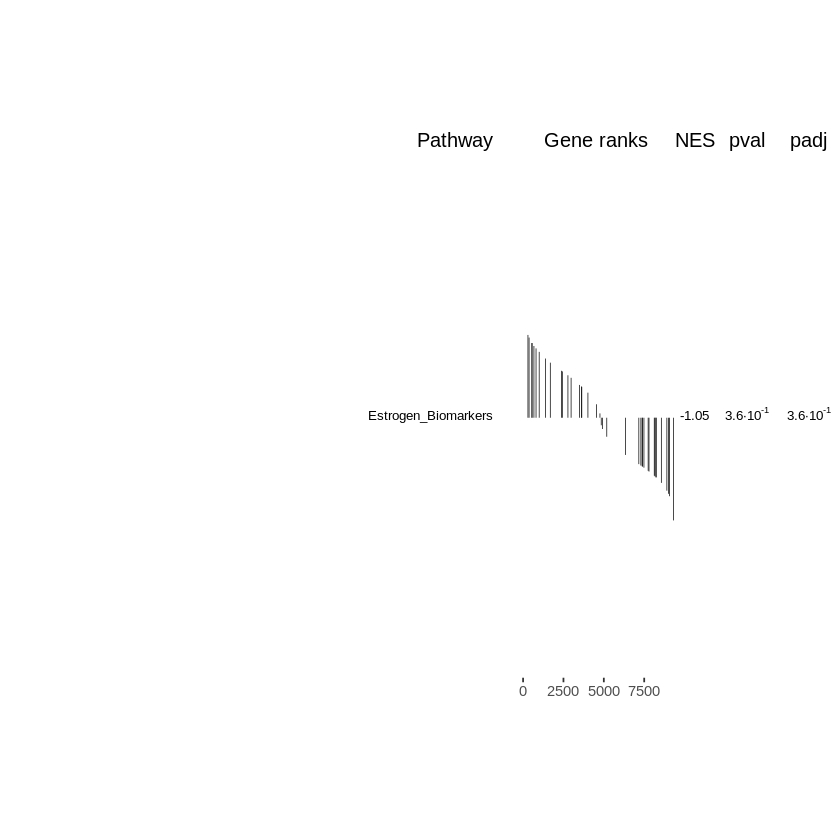

             Gene       Log2FC Reference    Regulation Reference_Regulation
PRSS23     PRSS23  0.248032056    1.3686   Upregulated          Upregulated
PDZK1       PDZK1  1.690163306    1.4229   Upregulated          Upregulated
RET           RET  1.593229744    1.6957   Upregulated          Upregulated
PGR           PGR  1.607879202    1.3750   Upregulated          Upregulated
CXCL12     CXCL12  0.673998102    1.6200   Upregulated          Upregulated
RAPGEFL1 RAPGEFL1  0.712485208    1.4629   Upregulated          Upregulated
CA12         CA12  0.399814101    1.3283   Upregulated          Upregulated
MYB           MYB  1.002424505    1.2700   Upregulated          Upregulated
AREG         AREG  0.314737877    1.5957   Upregulated          Upregulated
RCL1         RCL1  0.637228361    1.2917   Upregulated          Upregulated
CD44         CD44 -0.184567279    1.4567 Downregulated          Upregulated
EFNA1       EFNA1  0.075654054   -1.4800   Upregulated        Downregulated
CCNG2       

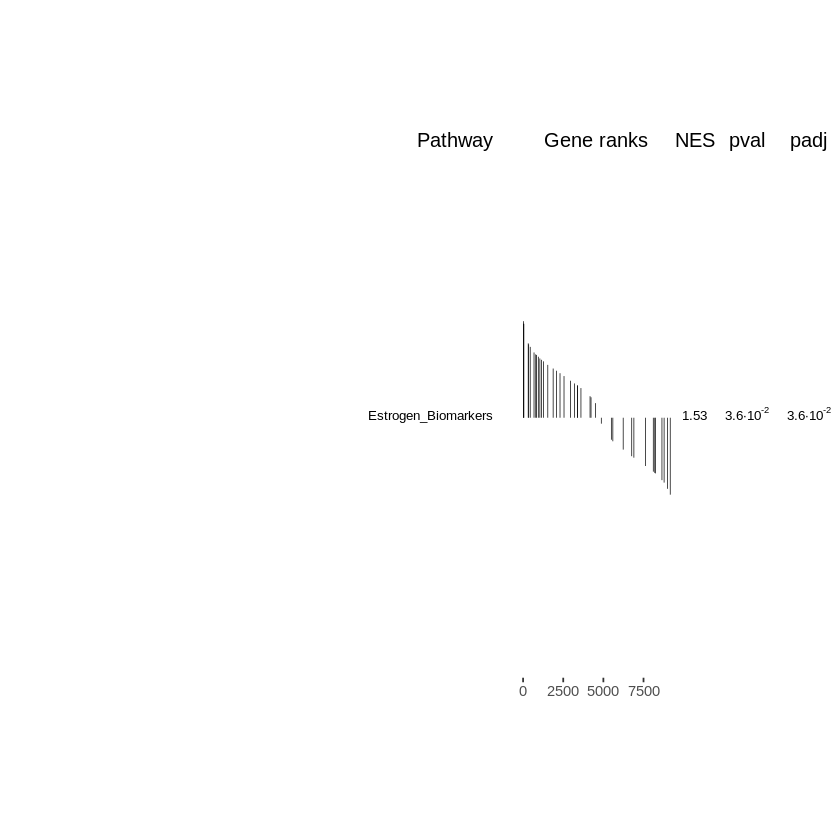

pdf 
  3

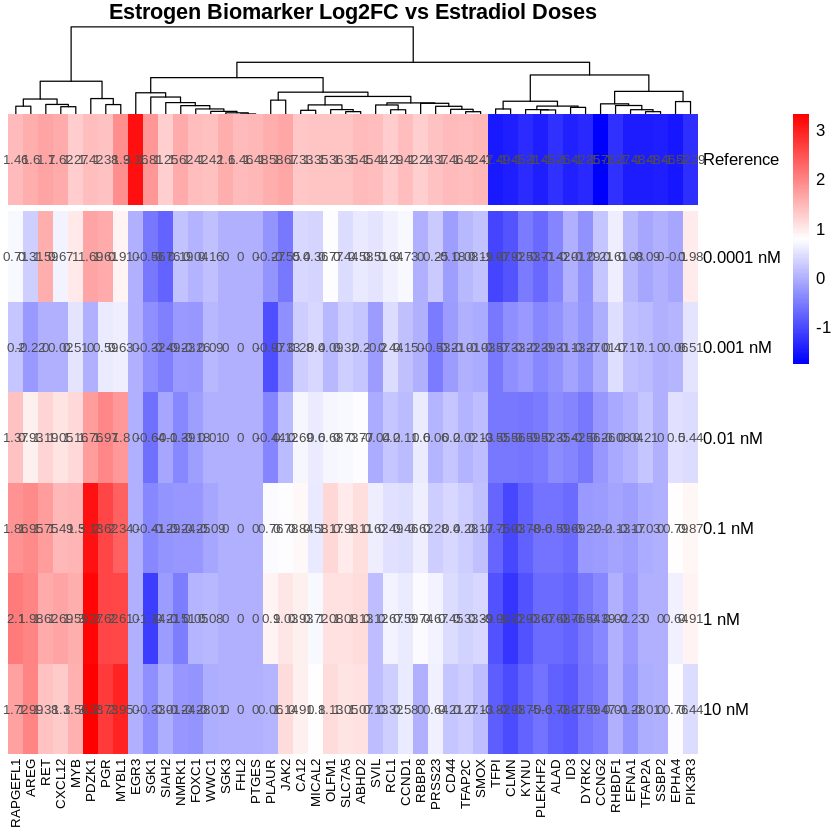

In [ ]:
file <- read.csv("/content/biomarkers.csv")
biomarker_df <- file[!is.na(file$Fold.change.in.the.46.gene.ER.Biomarker), ]
biomarker_genes <- biomarker_df$Gene
reference_fc <- biomarker_df$Fold.change.in.the.46.gene.ER.Biomarker
names(reference_fc) <- biomarker_genes
biomarker_gene_set <- list("Estrogen_Biomarkers" = biomarker_genes)
lfc_matrix <- data.frame(Gene = biomarker_genes)
for (i in names(control_files)) {
  file <- control_files[[i]]
  stats <- get_stats(file)
  stats <- sort(stats, decreasing = TRUE)
  stats <- stats[!is.na(names(stats)) & is.finite(stats)]
  estrogen_res <- fgsea(pathways = biomarker_gene_set, stats = stats, scoreType = "std", minSize = 1, maxSize = 500)
  print(estrogen_res)
  topPathwaysUp <- estrogen_res[ES > 0][head(order(pval), n = 10), pathway]
  topPathwaysDown <- estrogen_res[ES < 0][head(order(pval), n = 10), pathway]
  topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
  print(plotGseaTable(
    biomarker_gene_set[topPathways],
    stats,
    estrogen_res,
    gseaParam = 0.5,
    colwidths = c(10, 3, 0.8, 1.2, 1.2),
    pathwayLabelStyle = list(size = 8, color = "black"),
    valueStyle = list(size = 8)
  ))
  common_genes <- intersect(biomarker_genes, names(stats))
  estrogen_gene_stats <- data.frame(
    Gene                = common_genes,
    Log2FC              = stats[common_genes],
    Reference           = reference_fc[common_genes],
    Regulation          = ifelse(stats[common_genes] > 0, "Upregulated", "Downregulated"),
    Reference_Regulation = ifelse(reference_fc[common_genes] > 0, "Upregulated", "Downregulated")
  )
  print(estrogen_gene_stats)

  match_up <- sum(estrogen_gene_stats$Reference_Regulation == "Upregulated" & estrogen_gene_stats$Regulation == "Upregulated")
  match_down <- sum(estrogen_gene_stats$Reference_Regulation == "Downregulated" & estrogen_gene_stats$Regulation == "Downregulated")

  total_up <- sum(estrogen_gene_stats$Reference_Regulation == "Upregulated")
  total_down <- sum(estrogen_gene_stats$Reference_Regulation == "Downregulated")

  cat("Upregulated match:", match_up, "out of", total_up, "\n")
  cat("Downregulated match:", match_down, "out of", total_down, "\n")
  temp_df <- data.frame(Gene = common_genes, log2FC = stats[common_genes])
  colnames(temp_df)[2] <- i
  lfc_matrix <- full_join(lfc_matrix, temp_df, by = "Gene")
}
lfc_matrix$Reference <- reference_fc[lfc_matrix$Gene]

rownames(lfc_matrix) <- lfc_matrix$Gene
lfc_matrix <- lfc_matrix[, -1]
lfc_matrix <- lfc_matrix %>%
  rename_with(~ recode(.,
    "estra0.1" = "0.0001 nM",
    "estra1" = "0.001 nM",
    "estra10" = "0.01 nM",
    "estra100" = "0.1 nM",
    "estra1000" = "1 nM",
    "estradiol10000" = "10 nM"
  ))
ordered_cols <- c("Reference", "0.0001 nM", "0.001 nM", "0.01 nM", "0.1 nM", "1 nM", "10 nM")
lfc_matrix <- lfc_matrix[, intersect(ordered_cols, colnames(lfc_matrix))]
lfc_matrix[!is.finite(as.matrix(lfc_matrix))] <- 0
lfc_matrix_t <- t(lfc_matrix)
n_genes <- ncol(lfc_matrix_t)
n_conditions <- nrow(lfc_matrix_t)
cell_width <- 0.4
cell_height <- 0.4
pdf("estradiol_biomarker_heatmap.pdf", width = 12, height = 8)
pheatmap(
  mat = lfc_matrix_t,
  cluster_rows = FALSE,
  cluster_cols = TRUE,
  display_numbers = round(lfc_matrix_t, 2),
  main = "Estrogen Biomarker Log2FC vs Estradiol Doses",
  fontsize_col = 8,
  fontsize_row = 10,
  angle_col = 90,
  color = colorRampPalette(c("blue", "white", "red"))(200),
  na_col = "grey90",
  gaps_row = 1,
  border_color = NA
)
dev.off()

In [ ]:
write.csv(lfc_matrix_t,file="estra_estroBiomarker_Mat.csv")